In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/scpark/anaconda3/envs/ste/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# DEVICE의 출력으로 cuda가 나오는지 확인합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE :', DEVICE)

DEVICE : cuda


In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
    ])

# MNIST dataset을 준비합니다. 필요시 다운로드 받습니다.
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
print(train_data)

# MNIST dataset을 트레이닝과 테스트에 사용할 수 있도록 Data Loader를 만듭니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8)
print('done')

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
           )
done


In [4]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dims, T=1000):
        super().__init__()
        self.T = T
        embedding_min_frequency = 1.0
        embedding_max_frequency = 1000.0
        frequencies = torch.exp(torch.linspace(np.log(embedding_min_frequency), 
                                               np.log(embedding_max_frequency), embedding_dims//2))
        angular_speeds = 2.0 * np.pi * frequencies
        self.register_buffer("angular_speeds", angular_speeds)
        
    def forward(self, x):
        # x : (b,)
        x = x.unsqueeze(dim=1) / self.T
        embeddings = torch.cat([torch.sin(self.angular_speeds*x),
                                torch.cos(self.angular_speeds*x)], dim=1)
        return embeddings

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv = nn.Sequential(nn.BatchNorm2d(in_channels),
                                  nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                  nn.SiLU(),
                                  nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            
    def forward(self, x):
        # x : (b, c, h, w)
        residual = self.residual_layer(x)
        x = self.conv(x)
        y = x + residual
        return y

In [5]:
class Model(nn.Module):
    def __init__(self, in_channels=1,
                       hidden_channels=128,
                       n_layers=4,
                ):
        super().__init__()
        self.time_embedding = SinusoidalEmbedding(hidden_channels)
        self.prenet = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        
        self.encoders = nn.ModuleList()
        self.downs = nn.ModuleList()
        for i in range(n_layers):
            encoder = Conv2d(hidden_channels, hidden_channels)
            self.encoders.append(encoder)
            down = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=2, stride=2)
            self.downs.append(down)
            
        self.mid = Conv2d(hidden_channels, hidden_channels)
            
        self.decoders = nn.ModuleList()
        self.ups = nn.ModuleList()
        for i in range(n_layers):
            decoder = Conv2d(hidden_channels*2, hidden_channels)
            self.decoders.append(decoder)
            up = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=2, stride=2)
            self.ups.append(up)
            
        self.postnet = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)
            
    def forward(self, x, t):
        # x : (b, 3, h, w)
        # t : (b,)
        
        t = self.time_embedding(t)
        # (b, c, h, w)
        x = self.prenet(x)
        x = x + t[:, :, None, None]
        encodings = []
        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encodings.append(x)
            x = down(x)
            
        x = self.mid(x)
        
        encodings = encodings[::-1]
        for decoder, up, encoding in zip(self.decoders, self.ups, encodings):
            x = up(x)
            x = torch.cat([x, encoding], dim=1)
            x = decoder(x)
            
        x = self.postnet(x)    
        return x

In [6]:
class Diffusion():
    def __init__(self, min_signal_rate=0.0001, max_signal_rate=0.9999, T=1000):
        self.min_signal_rate = min_signal_rate
        self.max_signal_rate = max_signal_rate
        self.T = T
        
    def get_alpha_bar(self, signal_rates):
        alpha_bar = signal_rates**2
        return alpha_bar
    
    def get_alpha(self, signal_rates, prev_signal_rates):
        alpha_bar = self.get_alpha_bar(signal_rates)
        prev_alpha_bar = self.get_alpha_bar(prev_signal_rates)
        alpha = alpha_bar / prev_alpha_bar
        return alpha
    
    def get_beta(self, signal_rates, prev_signal_rates):
        alpha = self.get_alpha(signal_rates, prev_signal_rates)
        beta = 1 - alpha
        return beta
            
    def diffusion_schedule(self, t):
        # t : (b,)
        start_angle = np.arccos(self.max_signal_rate)
        end_angle = np.arccos(self.min_signal_rate)
        
        diffusion_angles = start_angle + t / self.T * (end_angle - start_angle)
        
        signal_rates = torch.cos(diffusion_angles)
        signal_rates = signal_rates[:, None, None, None]
        noise_rates = torch.sin(diffusion_angles)
        noise_rates = noise_rates[:, None, None, None]
        
        return noise_rates, signal_rates
    
    def get_loss(self, model, images):
        # model : Model instance
        # images : Tensor (b, c, h, w)
        
        # (b,)
        t = torch.randint(0, self.T, size=(len(images),), device=images.device)
        # (b,), (b,)
        noise_rates, signal_rates = self.diffusion_schedule(t)
        # (b, c, h, w)
        noises = torch.randn_like(images)
        # (b, c, h, w)
        noisy_images = signal_rates*images + noise_rates*noises
        # (b, c, h, w)
        pred_noises = model(noisy_images, t)
        # (,)
        loss = F.mse_loss(pred_noises, noises)
        
        return loss
    
    def sample_ddpm(self, model, num_images):
        initial_noise = torch.randn(num_images, 1, 32, 32).cuda()
        next_noisy_images = initial_noise
        
        for step in tqdm(range(self.T)):
            noisy_images = next_noisy_images
            # (b,)
            t = self.T - torch.ones(num_images,).cuda() * step - 1
            # (b,), (b,)
            noise_rates, signal_rates = self.diffusion_schedule(t)
            # (b,), (b,)
            _, prev_signal_rates = self.diffusion_schedule(t-1)
            # (b, 1, 1, 1)
            alpha = self.get_alpha(signal_rates, prev_signal_rates)
            # (b, 1, 1, 1)
            beta = self.get_beta(signal_rates, prev_signal_rates)
            # (b, c, h, w)
            pred_noises = model(noisy_images, t)
            # Algorithm 2. line 4.
            next_noisy_images = torch.rsqrt(alpha)*(noisy_images-beta/noise_rates*pred_noises)
            if step < self.T-1:
                next_noisy_images = next_noisy_images + torch.sqrt(beta)*torch.randn_like(pred_noises)
                    
        return next_noisy_images
            
    def sample_ddim(self, model, num_images):
        initial_noise = torch.randn(num_images, 1, 32, 32).cuda()
        next_noisy_images = initial_noise
        
        for step in tqdm(range(self.T)):
            noisy_images = next_noisy_images
            # (b,)
            t = self.T - torch.ones(num_images,).cuda() * step - 1
            # (b,), (b,)
            noise_rates, signal_rates = self.diffusion_schedule(t)
            # (b, c, h, w)
            pred_noises = model(noisy_images, t)
            # (b, c, h, w)
            pred_images = (noisy_images - noise_rates*pred_noises) / signal_rates
            
            t_next = t - 1
            # (b,), (b,)
            next_noise_rates, next_signal_rates = self.diffusion_schedule(t_next)
            # (b, c, h, w)
            next_noisy_images = next_signal_rates*pred_images + next_noise_rates*pred_noises
            
        return pred_images
    

In [7]:
import copy 

model = Model().cuda()
ema_model = copy.deepcopy(model)
diffusion = Diffusion()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
print('done')

done


100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 215.42it/s]


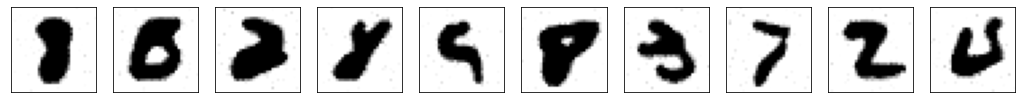

100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.18it/s]


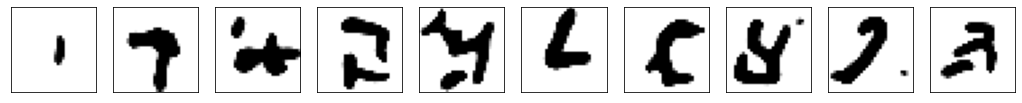

22010 0.02425004541873932
22020 0.04655323177576065
22030 0.02858572266995907
22040 0.04555976390838623
22050 0.0506553053855896
22060 0.029795877635478973
22070 0.029577791690826416
22080 0.03246427699923515
22090 0.030390098690986633
22100 0.029071930795907974
22110 0.029000191017985344
22120 0.029209576547145844
22130 0.03093794733285904
22140 0.03808842599391937
22150 0.02018510177731514
22160 0.018420811742544174
22170 0.02370626851916313
22180 0.03536956012248993
22190 0.037697434425354004
22200 0.024701964110136032
22210 0.023164663463830948
22220 0.039435166865587234
22230 0.050302259624004364
22240 0.025337064638733864
22250 0.056486524641513824
22260 0.030272116884589195
22270 0.03996124491095543
22280 0.032670896500349045
22290 0.039584681391716
22300 0.02204478718340397
22310 0.021882329136133194
22320 0.03215775638818741
22330 0.022196609526872635
22340 0.03426896780729294
22350 0.023570146411657333
22360 0.029022173956036568
22370 0.021859021857380867
22380 0.013029843568

In [ ]:
from IPython import display

# Backpropagation이 되도록 준비합니다.
step = 0
while(True):
    for batch_index, batch in enumerate(train_loader):
        # x : image (B, 1, 32, 32,)
        # t : class (B)
        images, _ = batch       
        images = images.cuda()
        images = images * 2 - 1
        
        # Set model mode to train and set gradient to zero
        model.train()
        model.zero_grad()
        
        # Get loss
        loss = diffusion.get_loss(model, images)
        loss.backward()
        optimizer.step()
        
        # EMA model
        ema_state_dict = ema_model.state_dict()
        state_dict = model.state_dict()
        for key in ema_state_dict.keys():
            ema_state_dict[key] = ema_state_dict[key] * 0.999 + state_dict[key] * 0.001
        ema_model.load_state_dict(ema_state_dict)
        
        if step % 10 == 0:
            print(step, loss.item())
        
        if step % 1000 == 0:
            display.clear_output()
            
            with torch.no_grad():
                samples = diffusion.sample_ddpm(ema_model, 10)
            samples = (samples + 1) / 2
            samples = torch.clamp(samples, 0, 1)
            _samples = samples.data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            plt.title('DDPM samples')
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(_samples[i, 0], cmap='binary')
                plt.xticks([])
                plt.yticks([])
            plt.show()
            
            with torch.no_grad():
                samples = diffusion.sample_ddim(ema_model, 10)
            samples = (samples + 1) / 2
            samples = torch.clamp(samples, 0, 1)
            _samples = samples.data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            plt.title('DDIM samples')
            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(_samples[i, 0], cmap='binary')
                plt.xticks([])
                plt.yticks([])
            plt.show()
            
        step += 1